A notebook which contains time series of SalishSeaCast model output and observed data within PugetSound. This script is designed so that changes in the observed and model data over time can be easily compared.

In [1]:
import sys
sys.path.append('/ocean/kflanaga/MEOPAR/analysis-keegan/notebooks/Tools')
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import numpy.polynomial.polynomial as poly
import matplotlib.pyplot as plt
import os
import math
import pandas as pd
import netCDF4 as nc
import datetime as dt
import gsw 
import matplotlib as mpl
import matplotlib.dates as mdates
import pickle
import xarray as xr
import datetime as dt
import Keegan_eval_tools as ket
from salishsea_tools import evaltools as et, viz_tools
from collections import OrderedDict

fs=16
mpl.rc('xtick', labelsize=fs)
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

import warnings
#warnings.filterwarnings('ignore')
from IPython.display import Markdown, display

%matplotlib inline

In [3]:
year=2010
modelversion='nowcast-green.201905'
PATH= '/results2/SalishSea/nowcast-green.201905/'
saveloc='/ocean/kflanaga/MEOPAR/savedData'

In [4]:
display(Markdown('''## Year: '''+ str(year)))

## Year: 2010

In [5]:
display(Markdown('''### Model output: '''+ PATH))

### Model output: /results2/SalishSea/nowcast-green.201905/

In [6]:
##### Loading in pickle file data
with open(os.path.join(saveloc,f'data_WADE_{modelversion}_{year}.pkl'),'rb') as hh:
    data=pickle.load(hh)
    
with open(os.path.join(saveloc,f'data_Pheo_{modelversion}_{year}.pkl'),'rb') as hh:
    data_Pheo=pickle.load(hh)

In [15]:
def TsFormat(df,obsvar,modvar,year,title,units='($\mu$M)'):
    fig,ax=plt.subplots(1,1,figsize=(18,8))
    ps=et.tsertser_graph(ax,df,obsvar,modvar,dt.datetime(year,1,1),dt.datetime(year,12,31))
    ax.legend(handles=ps,bbox_to_anchor=[1,.6,0,0])
    ax.set_xlabel(f'Date',fontsize=20)
    ax.set_ylabel(f'{obsvar} {units}',fontsize=20)
    ax.set_title(f'{title}', fontsize=22)
    yearsFmt = mdates.DateFormatter('%d %b')
    ax.xaxis.set_major_formatter(yearsFmt)
    return ax

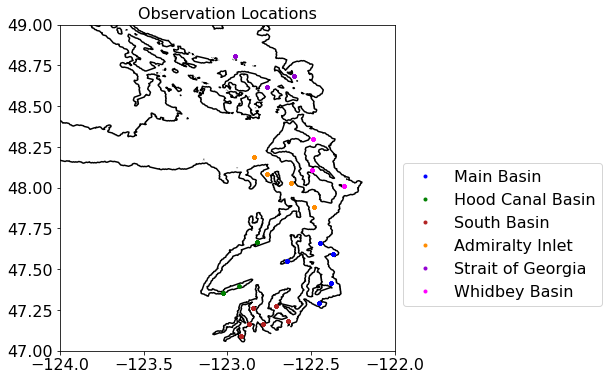

In [8]:
fig, ax = plt.subplots(1,1,figsize = (6,6))
with nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc') as grid:
    viz_tools.plot_coastline(ax, grid, coords = 'map',isobath=.1)
colors=('blue','green','firebrick','darkorange','darkviolet','fuchsia',
        'royalblue','darkgoldenrod','mediumspringgreen','deepskyblue')
datreg=dict()
for ind, iregion in enumerate(data.Basin.unique()):
    datreg[iregion] = data.loc[data.Basin==iregion]
    ax.plot(datreg[iregion]['Lon'], datreg[iregion]['Lat'],'.',
            color = colors[ind], label=iregion)
ax.set_ylim(47, 49)
ax.legend(bbox_to_anchor=[1,.6,0,0])
ax.set_xlim(-124, -122);
ax.set_title('Observation Locations');

In [9]:
#creating new dictionaries that make it easy to call on specific years.
datstat=dict()
for ind, istation in enumerate(data.Station.unique()):
    datstat[istation]=data.loc[data.Station == istation]
    
datreg=dict()
for iregion in data.Basin.unique():
    datreg[iregion] = data.loc[data.Basin==iregion] 
    
datyear=dict()
for ind, iyear in enumerate(data.dtUTC.dt.year.unique()):
    datyear[iyear] = data.loc[data.dtUTC.dt.year==iyear]
    
#Adding extra columns to assist in chlorophyll analysis.

Chl_to_N=1.8
data_Pheo['log_Chl']=ket.logt(data_Pheo['Chla_Lab'])
data_Pheo['log_mod_diatoms']=ket.logt(data_Pheo['mod_diatoms']*Chl_to_N)
data_Pheo['log_mod_ciliates']=ket.logt(data_Pheo['mod_ciliates']*Chl_to_N)
data_Pheo['log_mod_flagellates']=ket.logt(data_Pheo['mod_flagellates']*Chl_to_N)
data_Pheo['mod_Chl']=((data_Pheo['mod_diatoms']*Chl_to_N)+(data_Pheo['mod_ciliates']*Chl_to_N)+(data_Pheo['mod_flagellates']*Chl_to_N))
data_Pheo['log_mod_Chl']=ket.logt((data_Pheo['mod_diatoms']*Chl_to_N)+(data_Pheo['mod_ciliates']*Chl_to_N)+(data_Pheo['mod_flagellates']*Chl_to_N))

# defning a dictionary that brakes the data down by individual stations
datstat_Pheo=dict()
for ind, istation in enumerate(data_Pheo.Station.unique()):
    datstat_Pheo[istation]=data_Pheo.loc[data_Pheo.Station == istation]

datreg_Pheo=dict()
for iregion in data_Pheo.Basin.unique():
    datreg_Pheo[iregion] = data_Pheo.loc[data_Pheo.Basin==iregion] 
    
datyear_Pheo=dict()
for iyear in data_Pheo.dtUTC.dt.year.unique():
    datyear_Pheo[iyear] = data_Pheo.loc[data_Pheo.dtUTC.dt.year==iyear]


# Nitrate
## Observed nitrate and model nitrate over time with depth

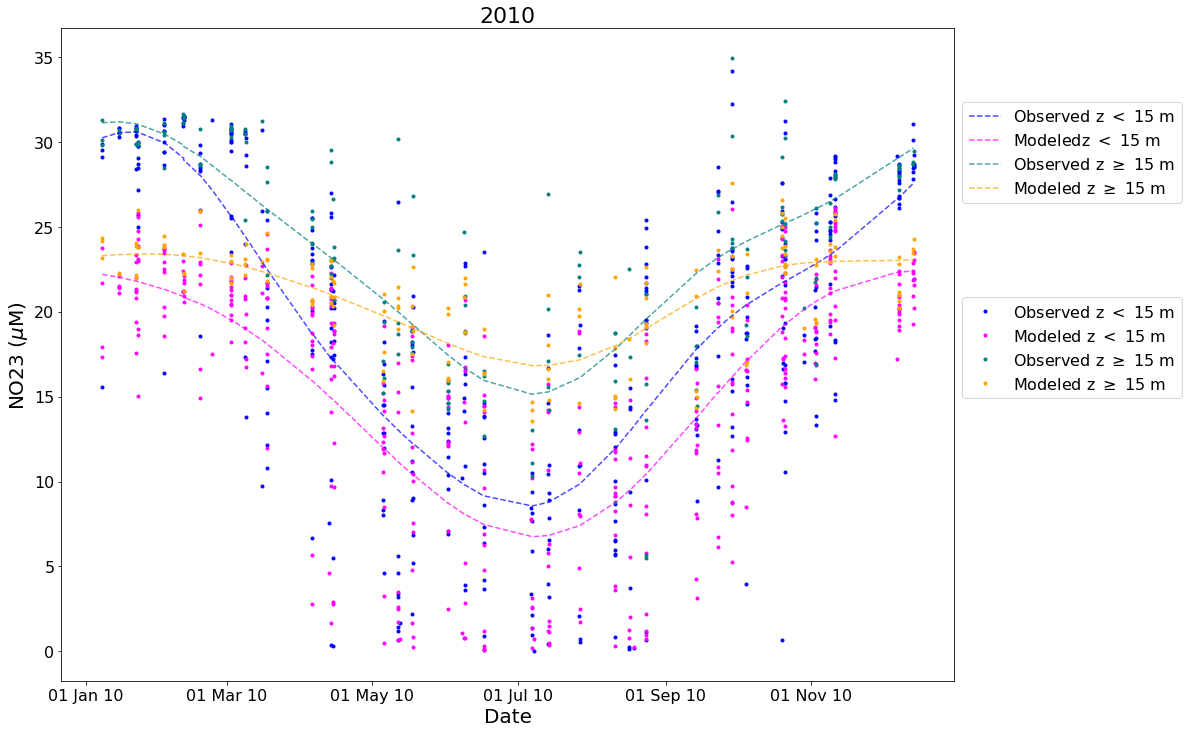

In [10]:
obsvar='NO23'
modvar='mod_nitrate'
start_date=dt.datetime(year,1,1)
end_date=dt.datetime(year,12,31)

ps,ax=ket.multi_timese_graph(data,year,obsvar,modvar,(16,12),depth_range=(15,15))
ps=ket.ts_trendline(ax,data,obsvar,modvar,start_date,end_date,'Z',(15,15),'z','m')
ax.legend(handles=ps,bbox_to_anchor=[1,.9,0,0])

## Observed nitrate and model nitrate over time for different regions

I think that the depths thing would actually be better as a dictionary with each region name equaling a tuple that can be sent into sepvals. 

In [14]:
data.Basin.unique()

array(['Main Basin', 'Hood Canal Basin', 'South Basin', 'Admiralty Inlet',
       'Strait of Georgia', 'Whidbey Basin'], dtype=object)

In [18]:
regdepths= {
    'Main Basin': (12,12),
    'Hood Canal Basin': (7,7),
    'Whidbey Basin': (10,10),
    'South Basin': (15,15),
    'Admiralty Inlet': (30,30),
    'Strait of Georgia': (15,15),
}

In [27]:
regdepths['Main Basin'][0]

12

In [37]:
def TsByRegion(datreg,regions,obsvar,modvar,year,regdepths,loc='lower left',units='($\mu$M)',trendline=False):
    '''Creates time series for each region specified by the user. 
    
    :arg datreg: a dictionary which contains data for each seperate region. 
    :type : dictionary
    
    :arg regions: A list of regions which need to be graphed. 
    :type : list of strings
    
    :arg obsvar,modvar: The name of the observed and model variables you wish 
                        to compare to each other.
    :type :string
    
    :arg regdepths: A dictionary which contains tuples for each region. 
                    These tuples each contain integers or floats for 
    :type : dictionary
    '''
    fig,ax=plt.subplots(math.ceil(len(regions)),2,figsize=(13,26))
    for ri,axi in zip(regions,ax): 
        dfless=datreg[ri][datreg[ri].Z < regdepths[ri][0]]
        dfgreat=datreg[ri][datreg[ri].Z > regdepths[ri][1]]
        ps0=ket.tsertser_graph(axi[0],dfless,obsvar,modvar,dt.datetime(year,1,1),
                           dt.datetime(year,12,31))
        ps1=ket.tsertser_graph(axi[1],dfgreat,obsvar,modvar,dt.datetime(year,1,1),
                           dt.datetime(year,12,31))
        axi[0].set_title(f'Time series for {ri} less than {regdepths[ri][0]} meters', fontsize=13)
        axi[1].set_title(f'Time series for {ri} greater than {regdepths[ri][1]} meters', fontsize=13)
        for axj in axi:
            axj.legend(handles=ps,prop={'size': 10},loc=loc)
            axj.set_xlabel(f'Date',fontsize=13)
            axj.set_ylabel(f'{obsvar} {units}',fontsize=13)
            yearsFmt = mdates.DateFormatter('%d %b')
            axj.xaxis.set_major_formatter(yearsFmt)
            for tick in axj.xaxis.get_major_ticks():
                tick.label.set_fontsize(13)
            for tick in axj.yaxis.get_major_ticks():
                tick.label.set_fontsize(13)
            plt.tight_layout()
            plt.setp(axj.get_xticklabels(), rotation=30, horizontalalignment='right')
        if trendline == True:
            ket.ts_trendline(axi[0],dfless,obsvar,modvar,dt.datetime(year,1,1),
                         dt.datetime(year,12,31))
            ket.ts_trendline(axi[1],dfgreat,obsvar,modvar,dt.datetime(year,1,1),
                         dt.datetime(year,12,31))
    return ax
        

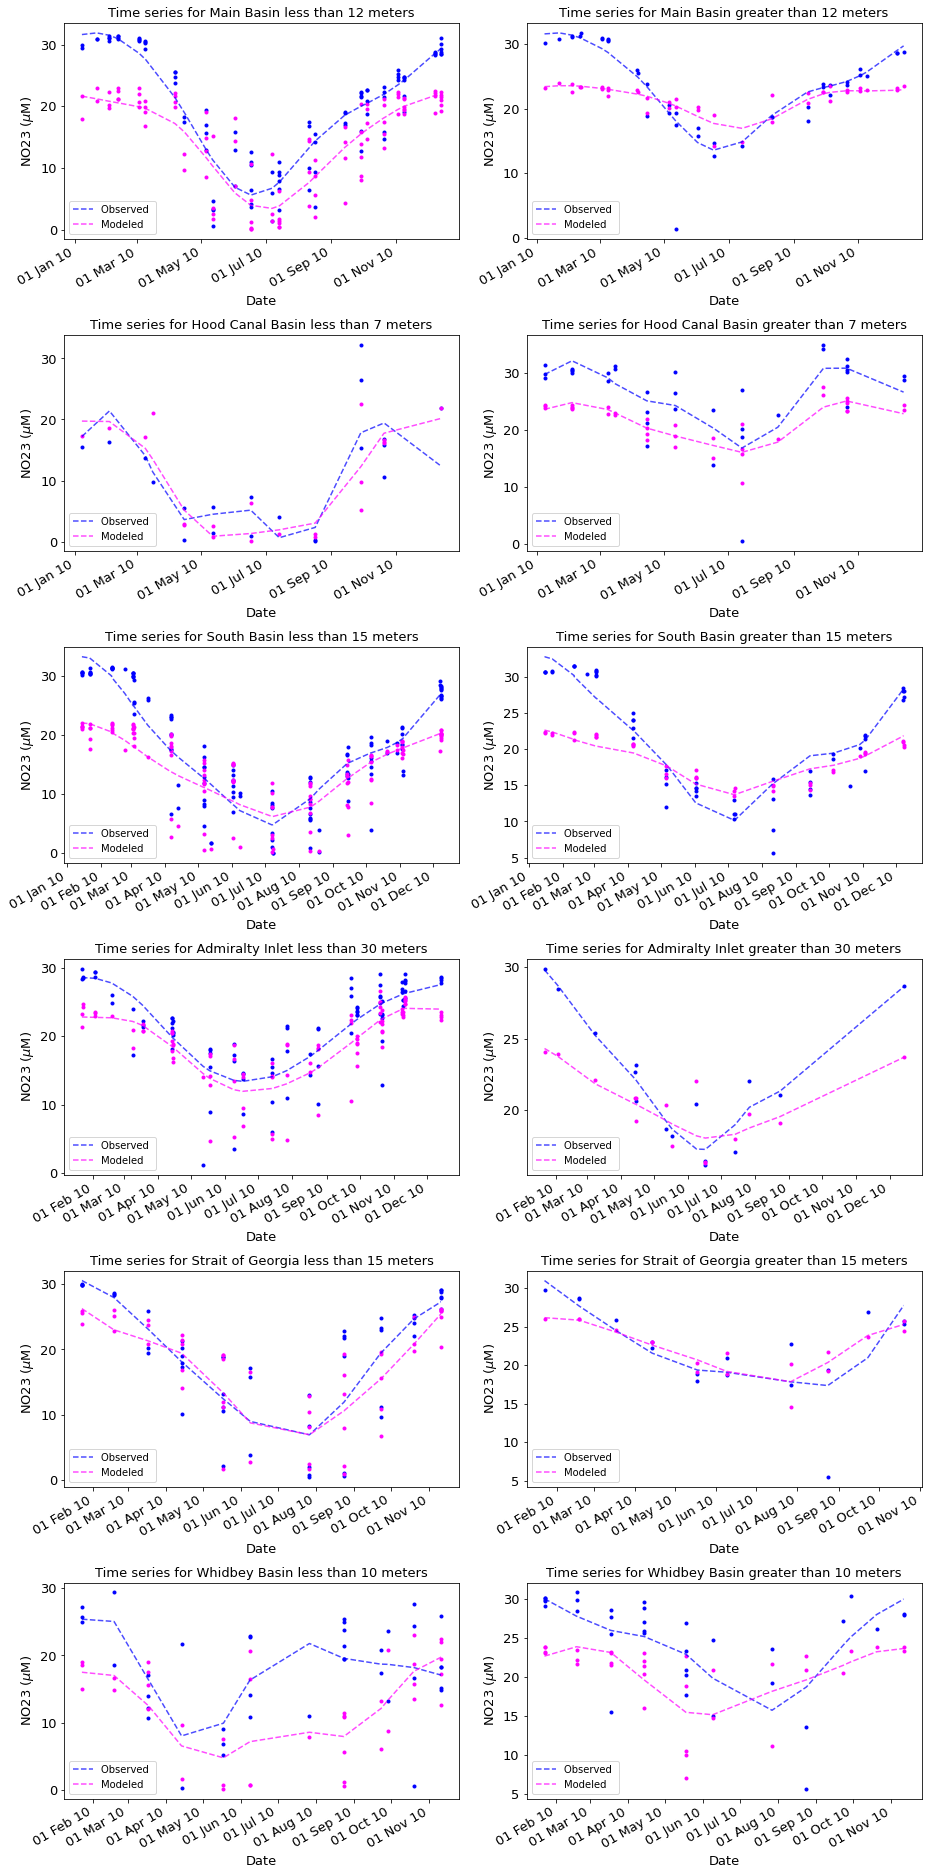

In [38]:
ax=TsByRegion(datreg,data.Basin.unique(),obsvar,modvar,year,regdepths,trendline=True)

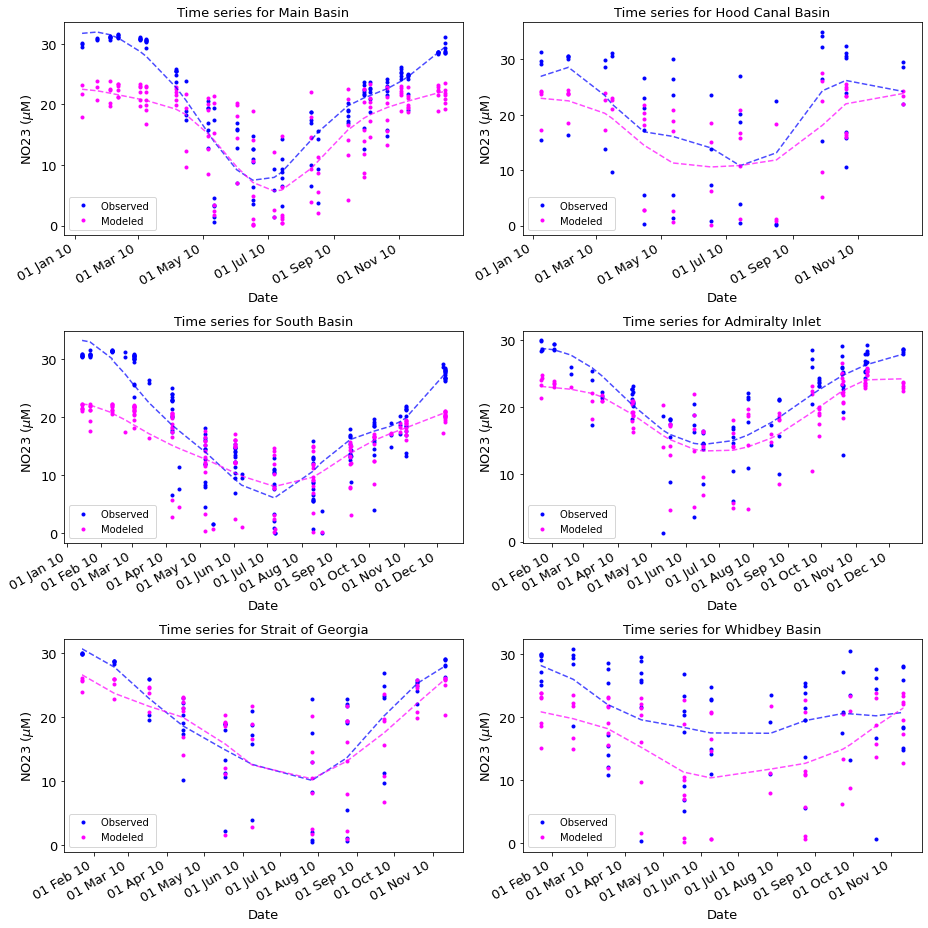

In [11]:
ax=TsByRegion(datreg,data.Basin.unique(),obsvar,modvar,year,trendline=True)

## Observed nitrate and model nitrate over time individual depths

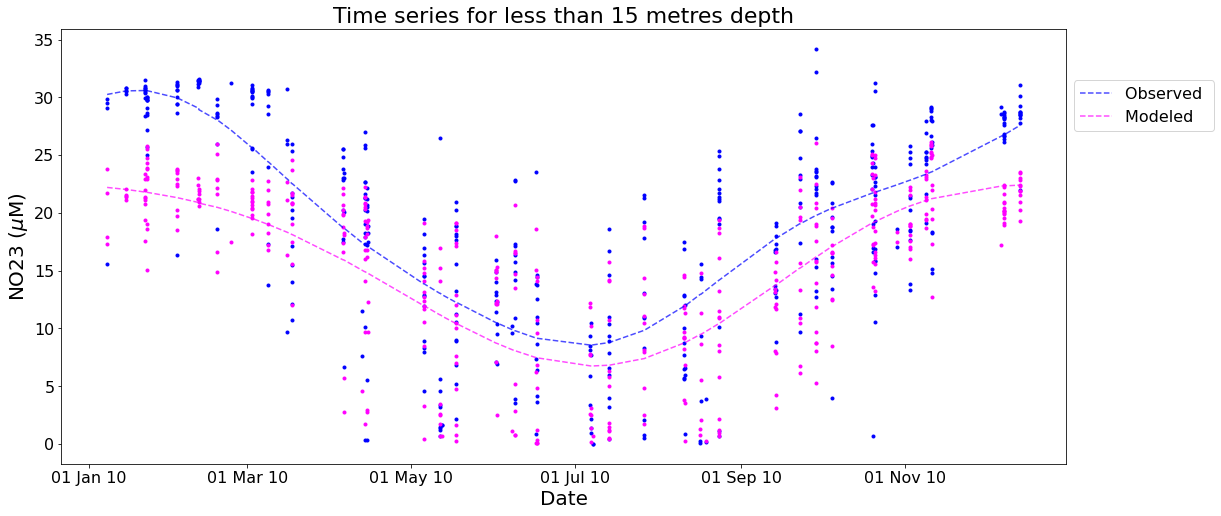

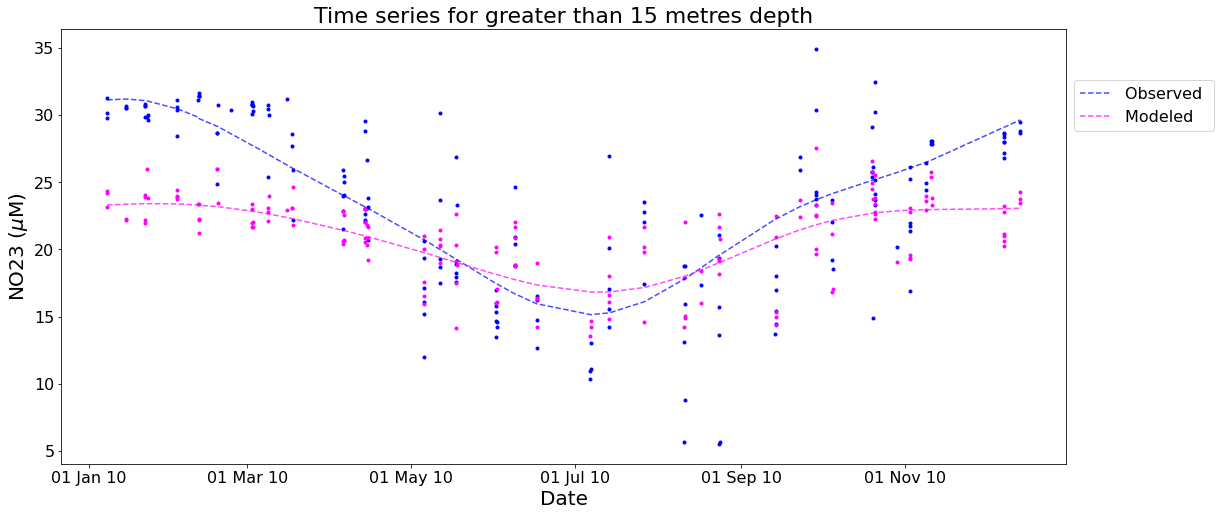

In [12]:
title='Time series for less than 15 metres depth'
ax=TsFormat(data[data.Z < 15],obsvar,modvar,year,title)
ps=ket.ts_trendline(ax,data[data.Z < 15],obsvar,modvar,start_date,end_date)
ax.legend(handles=ps,bbox_to_anchor=[1,.9,0,0])

title='Time series for greater than 15 metres depth'
ax=TsFormat(data[data.Z > 15],obsvar,modvar,year,title)
ps=ket.ts_trendline(ax,data[data.Z > 15],obsvar,modvar,start_date,end_date)
ax.legend(handles=ps,bbox_to_anchor=[1,.9,0,0])

## Model Error over time

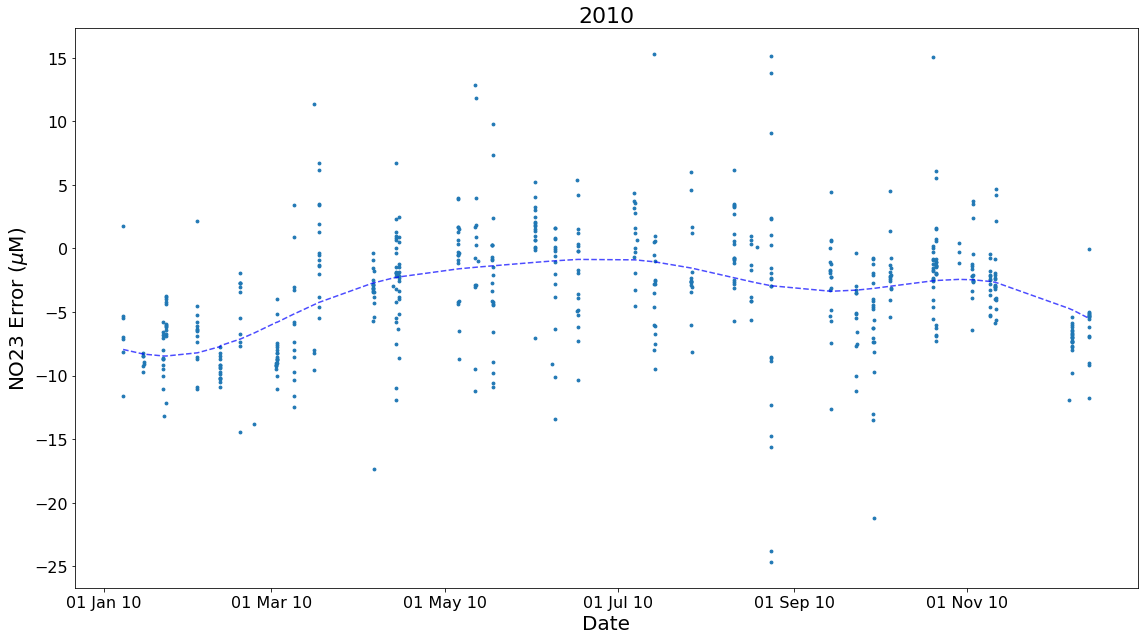

In [13]:
ax=ket.multi_timerror_graph(data,datyear,year,obsvar,modvar,(16,9))
ps=ket.ts_trendline(ax,data,obsvar,modvar,start_date,end_date,error=True)

# Silicon
## Observed Silicon and model Silicon over time with depth

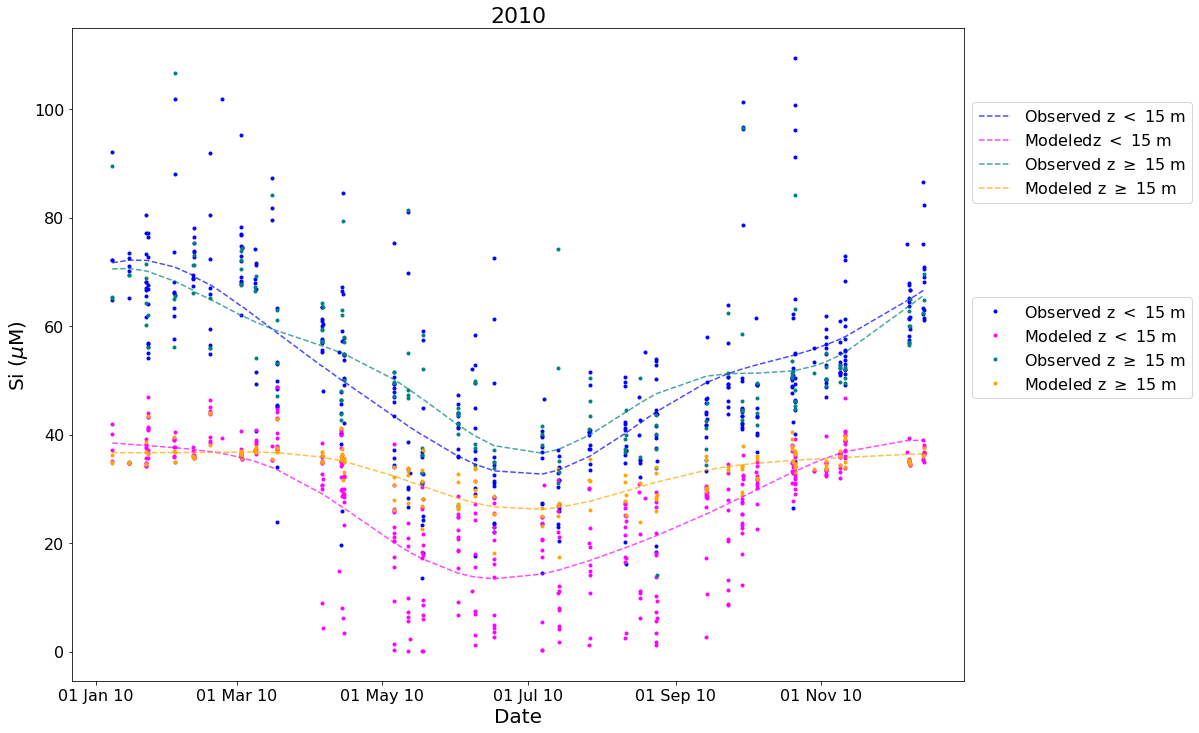

In [14]:
obsvar='Si'
modvar='mod_silicon'
start_date=dt.datetime(year,1,1)
end_date=dt.datetime(year,12,31)

ps,ax=ket.multi_timese_graph(data,year,obsvar,modvar,(16,12),depth_range=(15,15))
ps=ket.ts_trendline(ax,data,obsvar,modvar,start_date,end_date,'Z',(15,15),'z','m')
ax.legend(handles=ps,bbox_to_anchor=[1,.9,0,0])

## Observed Silicon and model Silicon over time for different regions

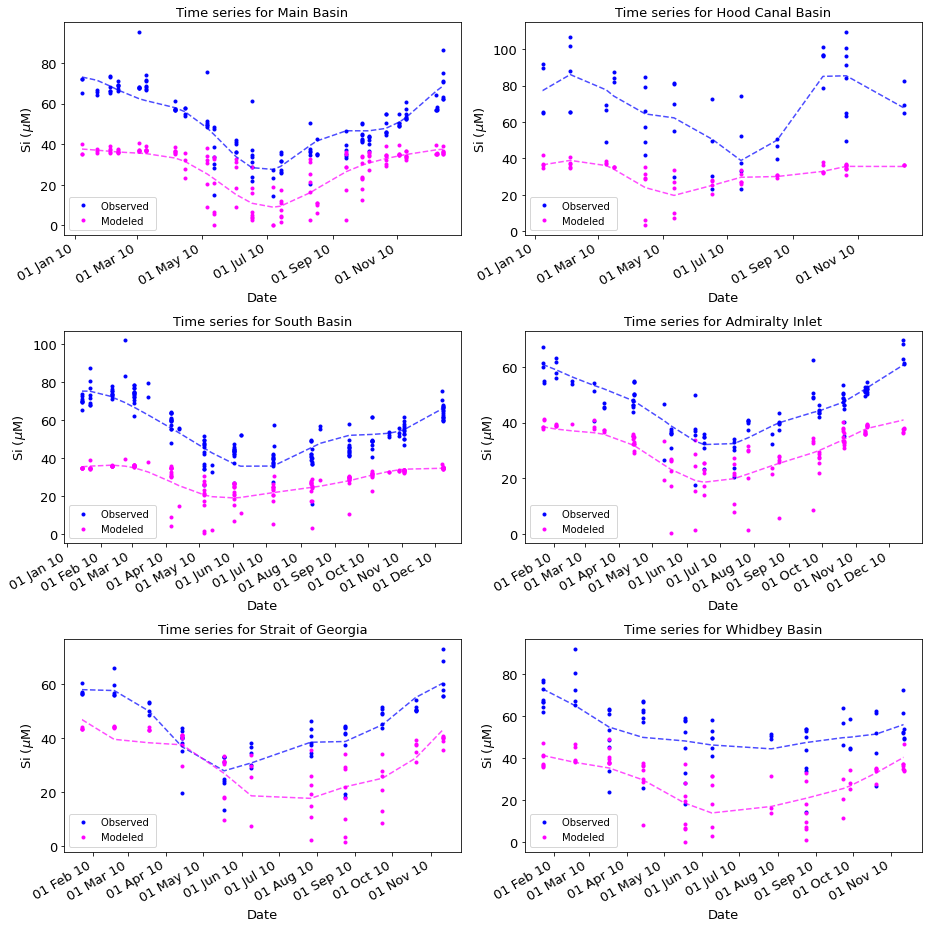

In [15]:
ax=ket.TsByRegion(datreg,data.Basin.unique(),obsvar,modvar,year,trendline=True)

## Observed Silicon and model Silicon over time individual depths

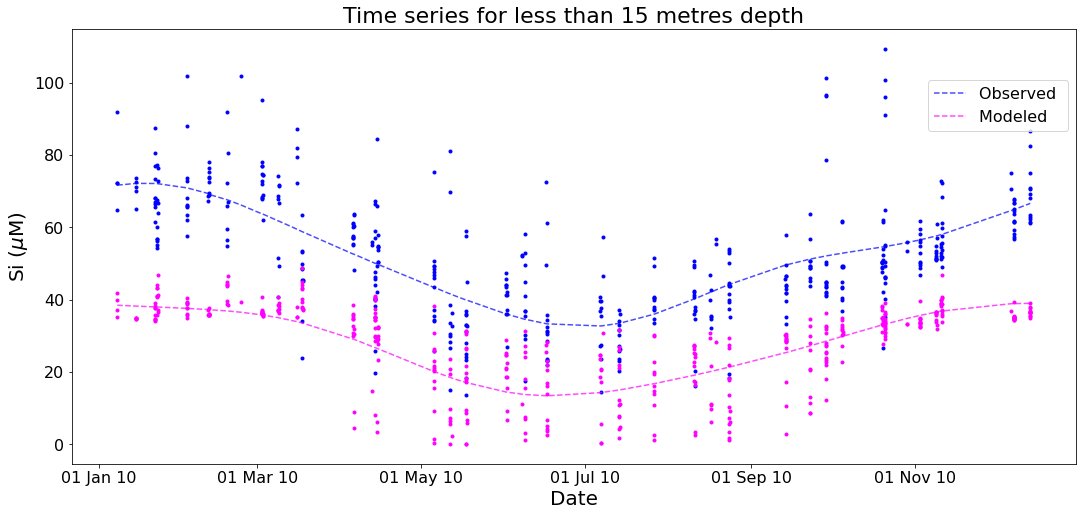

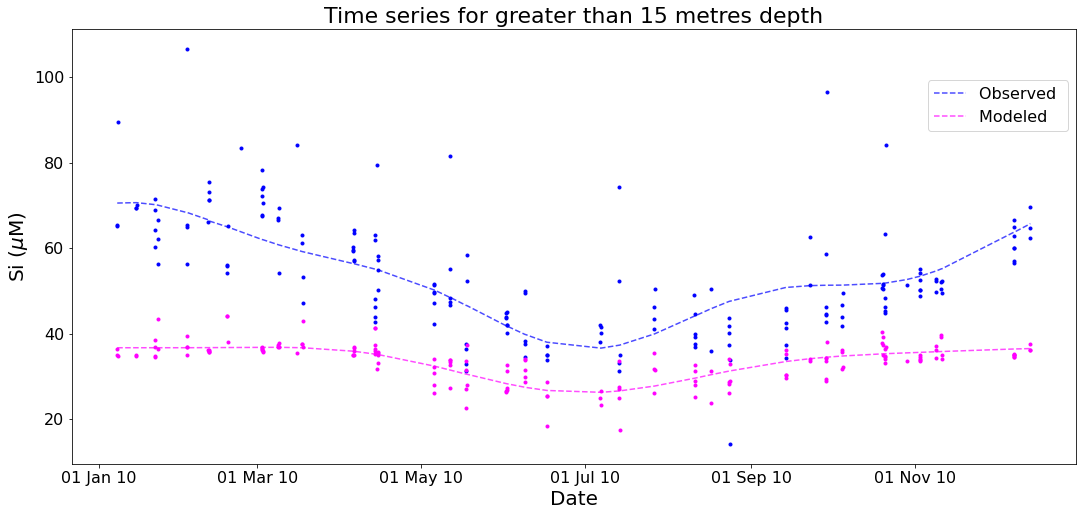

In [16]:
title='Time series for less than 15 metres depth'
ax=TsFormat(data[data.Z < 15],obsvar,modvar,year,title)
ps=ket.ts_trendline(ax,data[data.Z < 15],obsvar,modvar,start_date,end_date)
ax.legend(handles=ps,bbox_to_anchor=[1,.9,0,0])

title='Time series for greater than 15 metres depth'
ax=TsFormat(data[data.Z > 15],obsvar,modvar,year,title)
ps=ket.ts_trendline(ax,data[data.Z > 15],obsvar,modvar,start_date,end_date)
ax.legend(handles=ps,bbox_to_anchor=[1,.9,0,0])

## Model Error over time

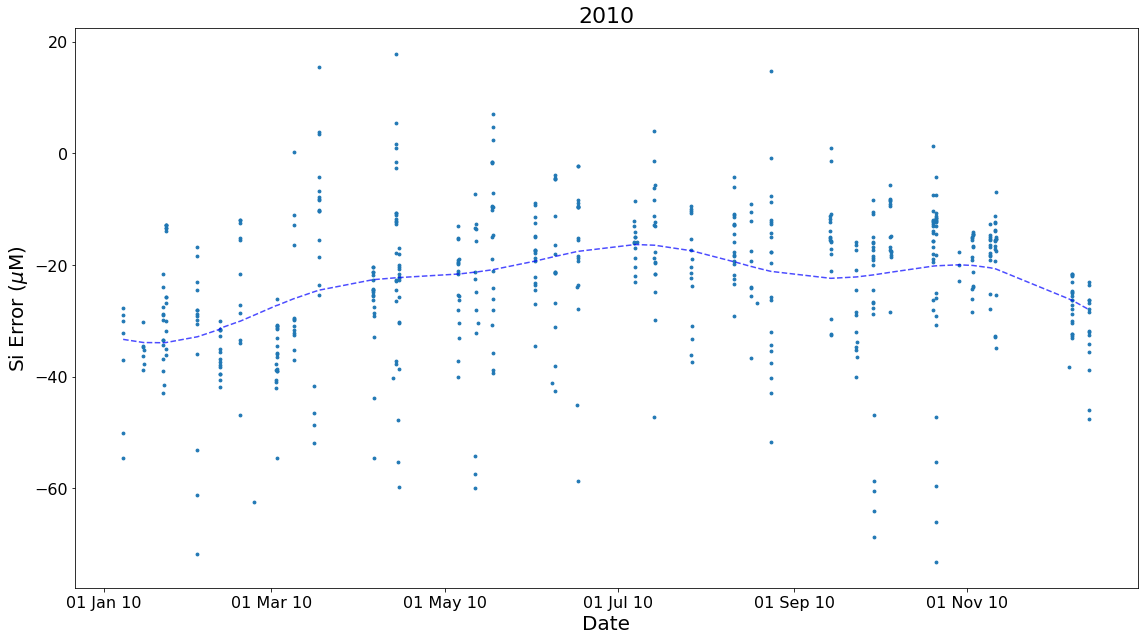

In [17]:
ax=ket.multi_timerror_graph(data,datyear,year,obsvar,modvar,(16,9))
ps=ket.ts_trendline(ax,data,obsvar,modvar,start_date,end_date,error=True)

# Ammonium

## Observed Ammonium and model Ammonium over time by 

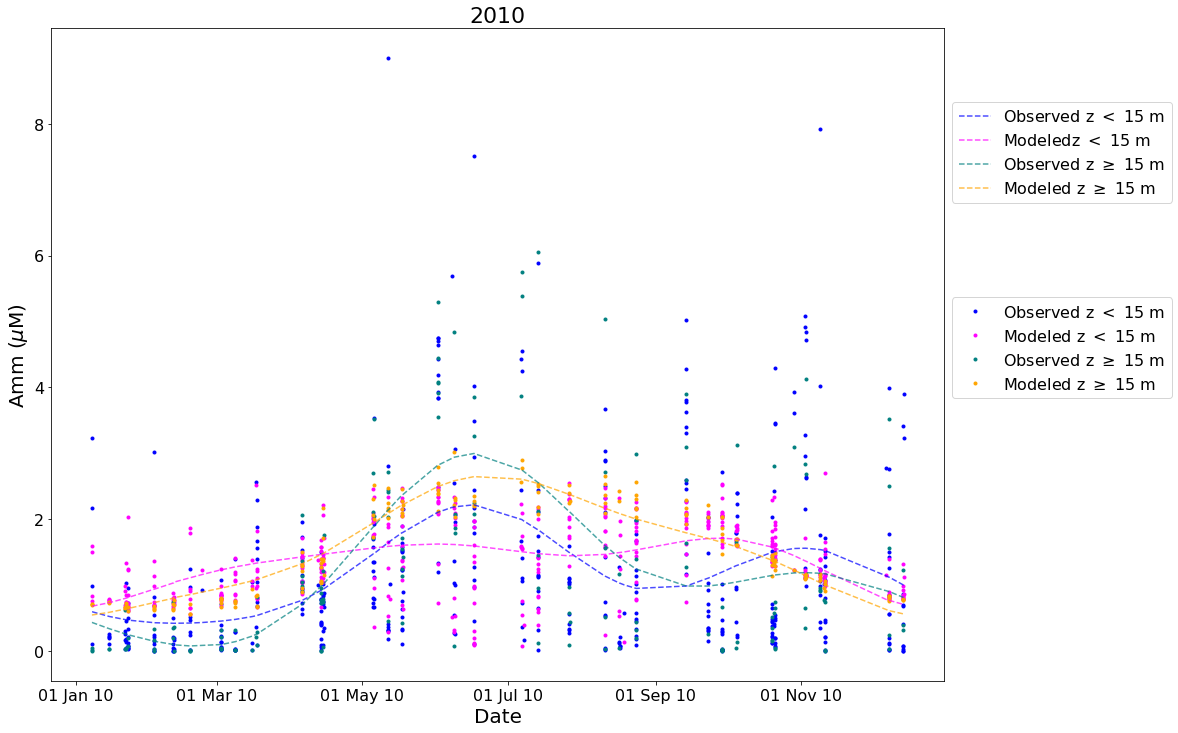

In [18]:
obsvar='Amm'
modvar='mod_ammonium'
start_date=dt.datetime(year,1,1)
end_date=dt.datetime(year,12,31)

ps,ax=ket.multi_timese_graph(data,year,obsvar,modvar,(16,12),depth_range=(15,15))
ps=ket.ts_trendline(ax,data,obsvar,modvar,start_date,end_date,'Z',(15,15),'z','m')
ax.legend(handles=ps,bbox_to_anchor=[1,.9,0,0])

## Observed Ammonium and model Ammonium over time for different regions

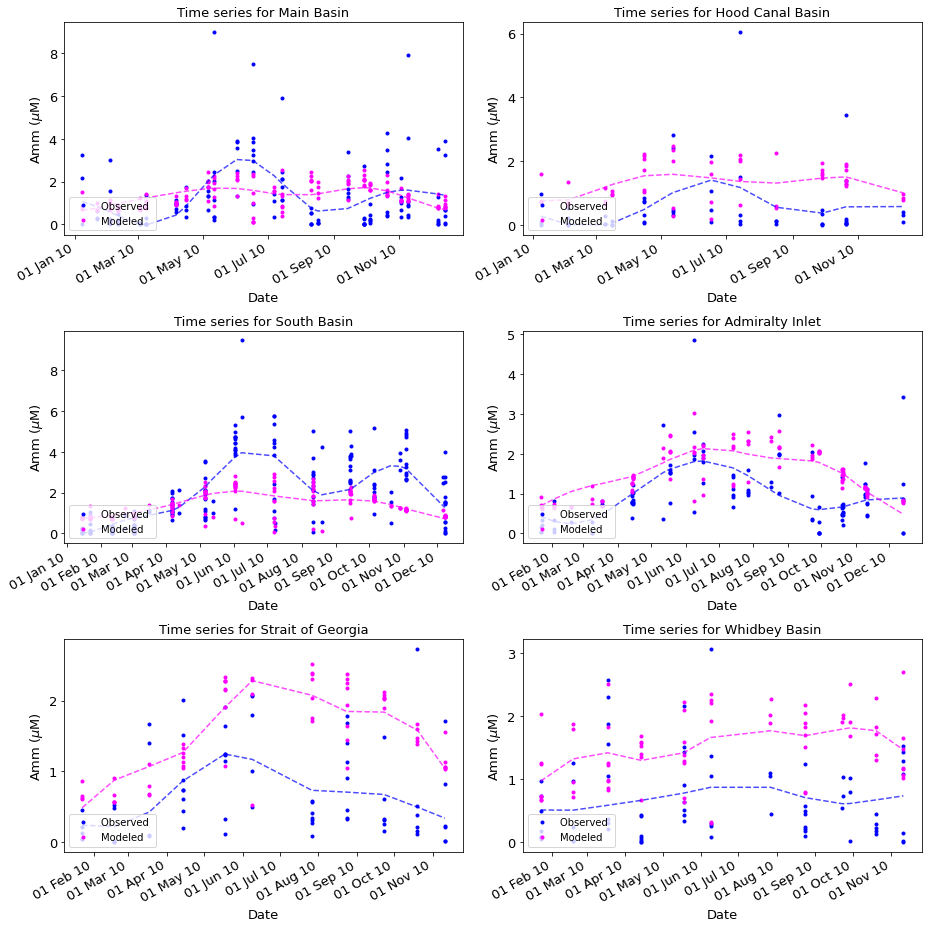

In [19]:
ax=ket.TsByRegion(datreg,data.Basin.unique(),obsvar,modvar,year,trendline=True)

## Observe Ammonium and model Ammonium over time individual depths

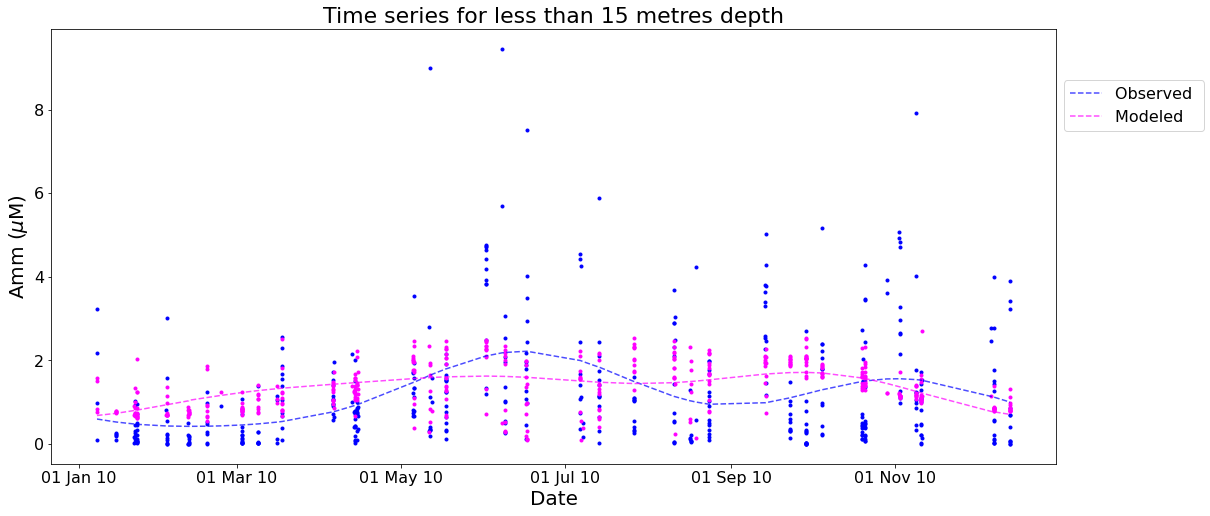

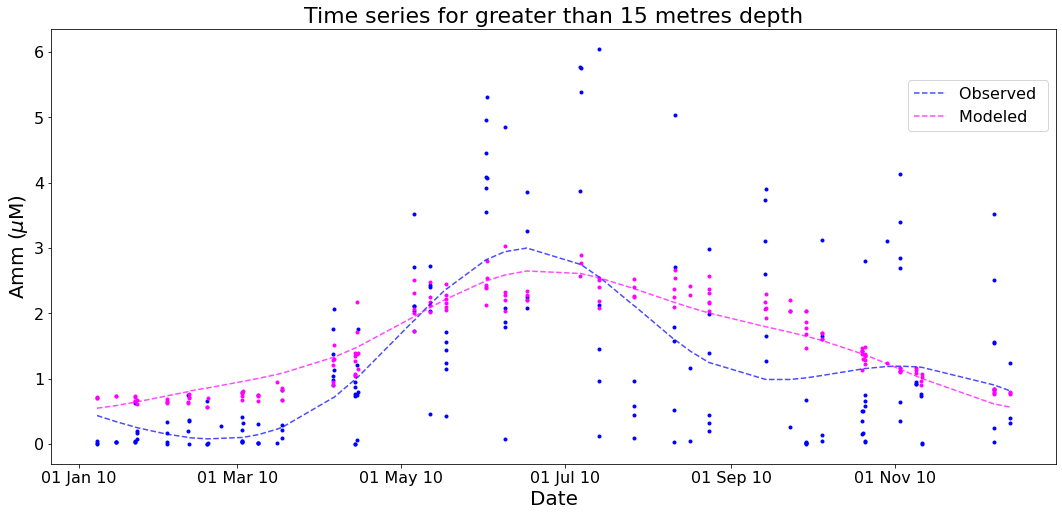

In [20]:
title='Time series for less than 15 metres depth'
ax=TsFormat(data[data.Z < 15],obsvar,modvar,year,title)
ps=ket.ts_trendline(ax,data[(data.Z < 15)],obsvar,modvar,start_date,end_date)
ax.legend(handles=ps,bbox_to_anchor=[1,.9,0,0])

title='Time series for greater than 15 metres depth'
ax=TsFormat(data[data.Z > 15],obsvar,modvar,year,title)
ps=ket.ts_trendline(ax,data[data.Z > 15],obsvar,modvar,start_date,end_date)
ax.legend(handles=ps,bbox_to_anchor=[1,.9,0,0])

# Error vs time of year

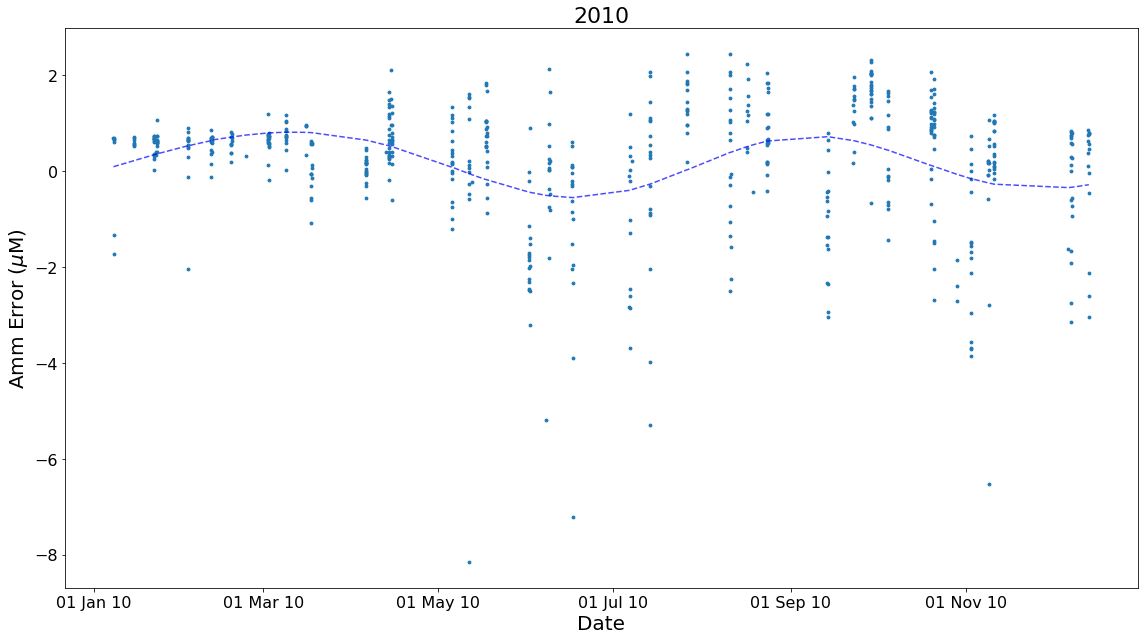

In [21]:
ax=ket.multi_timerror_graph(data,datyear,year,obsvar,modvar,(16,9))
ps=ket.ts_trendline(ax,data,obsvar,modvar,start_date,end_date,error=True)

# Salinity

## Observed Salinity and model Salinity over time 

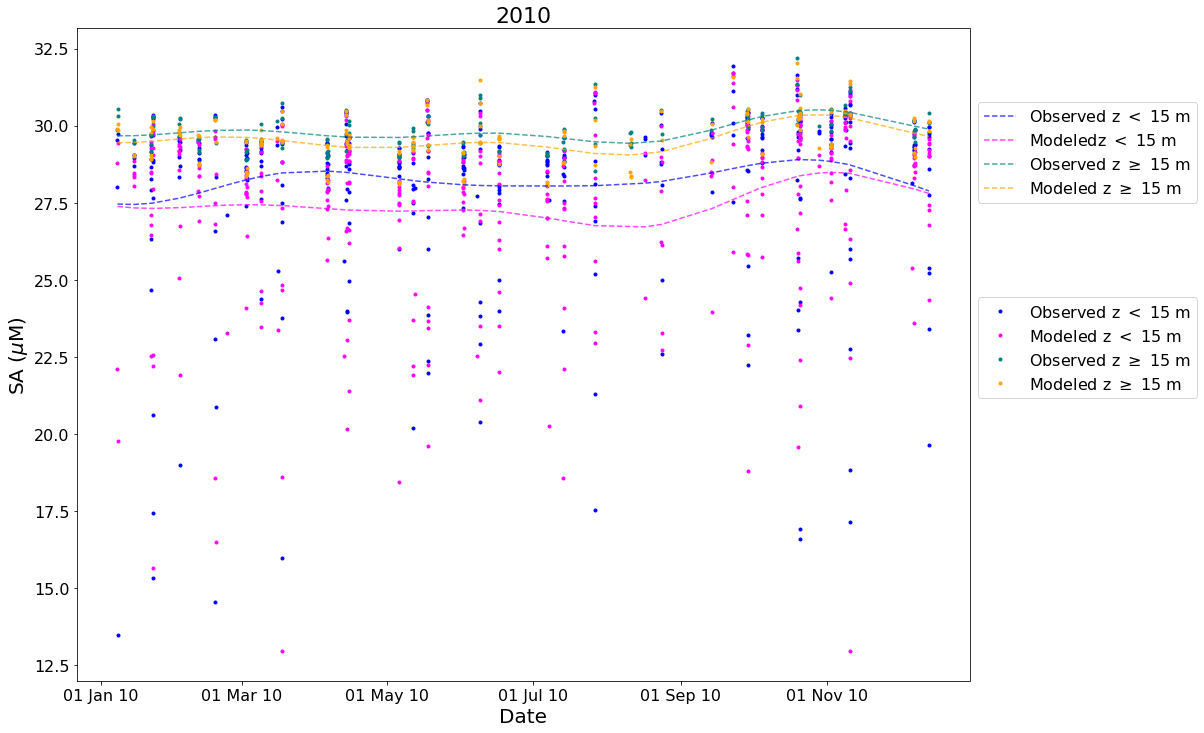

In [22]:
obsvar='SA'
modvar='mod_vosaline'
start_date=dt.datetime(year,1,1)
end_date=dt.datetime(year,12,31)

ps,ax=ket.multi_timese_graph(data,year,obsvar,modvar,(16,12),depth_range=(15,15))
ps=ket.ts_trendline(ax,data,obsvar,modvar,start_date,end_date,'Z',(15,15),'z','m')
ax.legend(handles=ps,bbox_to_anchor=[1,.9,0,0])

## Observed Salinity and model Salinity over time for different regions

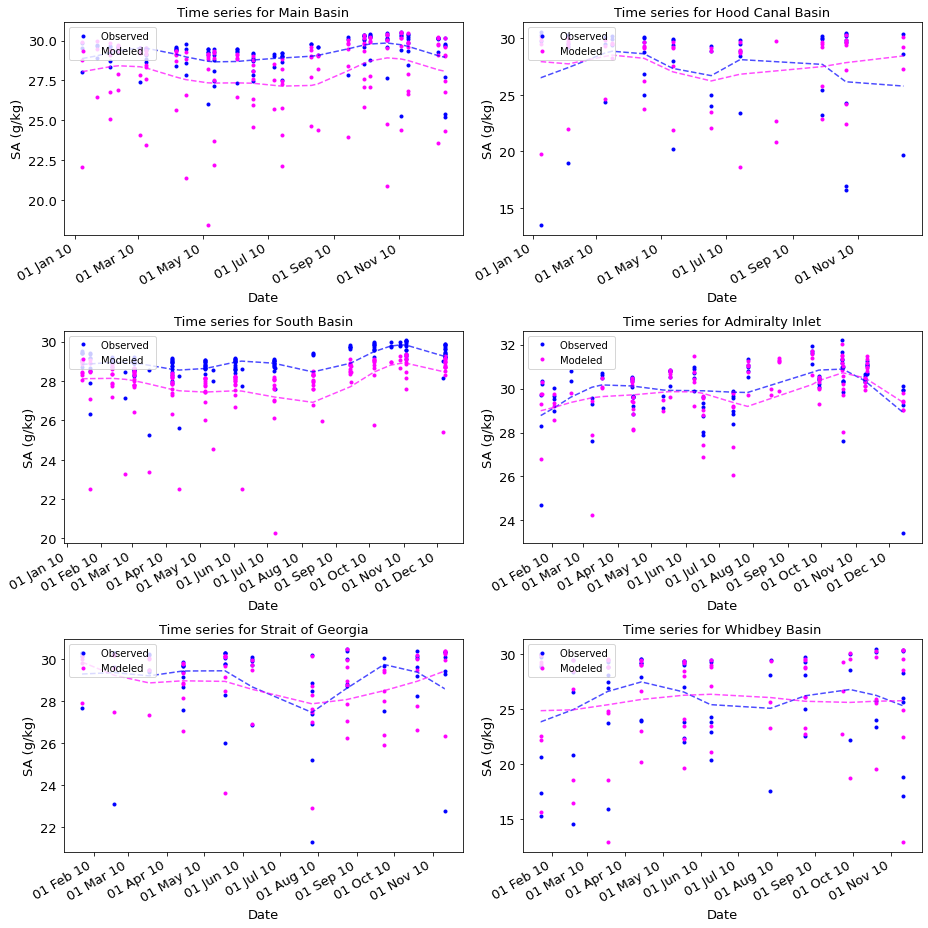

In [23]:
ax=ket.TsByRegion(datreg,data.Basin.unique(),obsvar,modvar,year,loc='upper left',units='(g/kg)',trendline=True)

## Observe Salinity and model Salinity over time individual depths

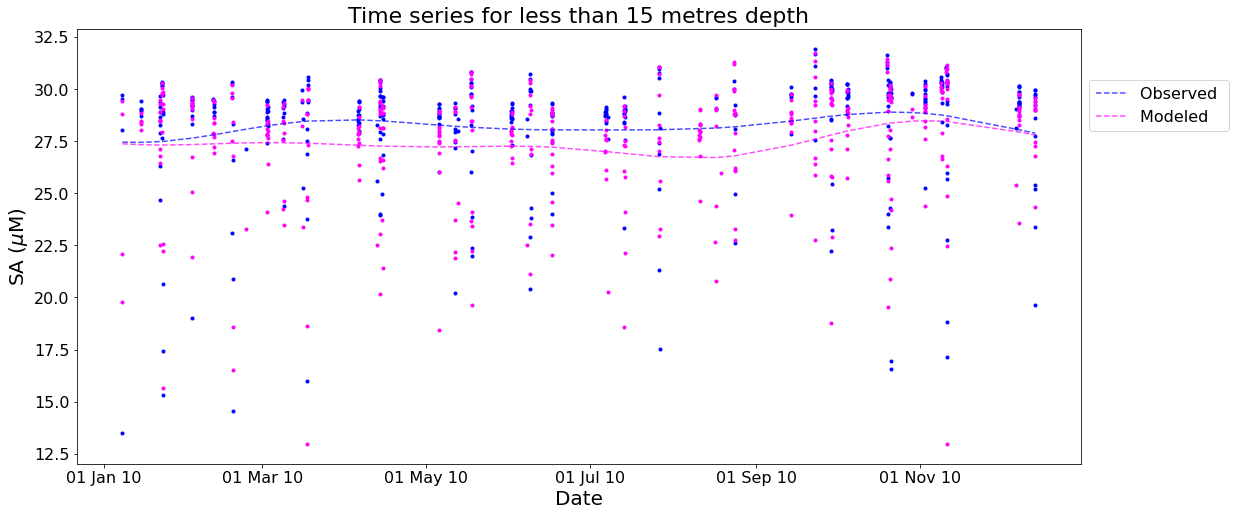

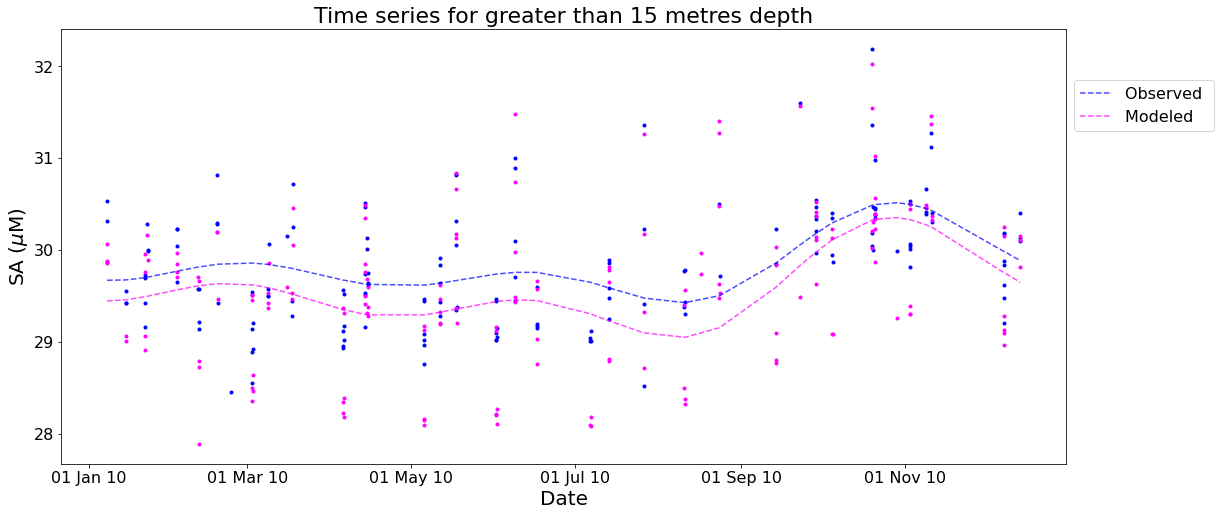

In [24]:
title='Time series for less than 15 metres depth'
ax=TsFormat(data[data.Z < 15],obsvar,modvar,year,title)
ps=ket.ts_trendline(ax,data[data.Z < 15],obsvar,modvar,start_date,end_date)
ax.legend(handles=ps,bbox_to_anchor=[1,.9,0,0])

title='Time series for greater than 15 metres depth'
ax=TsFormat(data[data.Z > 15],obsvar,modvar,year,title)
ps=ket.ts_trendline(ax,data[data.Z > 15],obsvar,modvar,start_date,end_date)
ax.legend(handles=ps,bbox_to_anchor=[1,.9,0,0])

# Error vs time of year

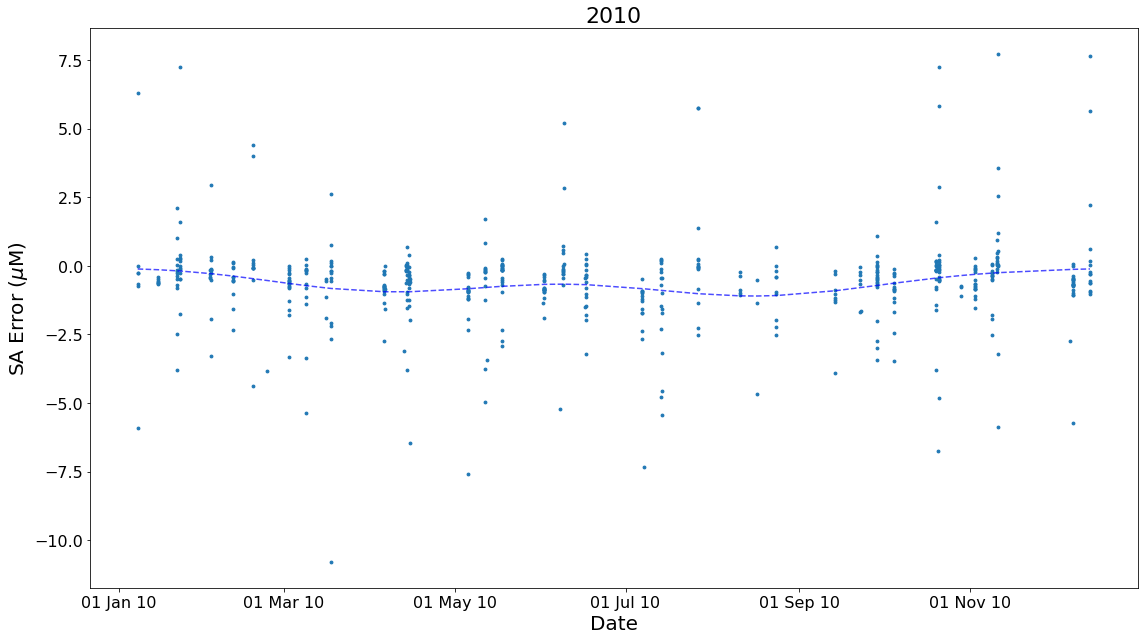

In [25]:
ax=ket.multi_timerror_graph(data,datyear,year,obsvar,modvar,(16,9))
ps=ket.ts_trendline(ax,data,obsvar,modvar,start_date,end_date,error=True)

# Temperature

## Observed Temperature and model Temperature over time 

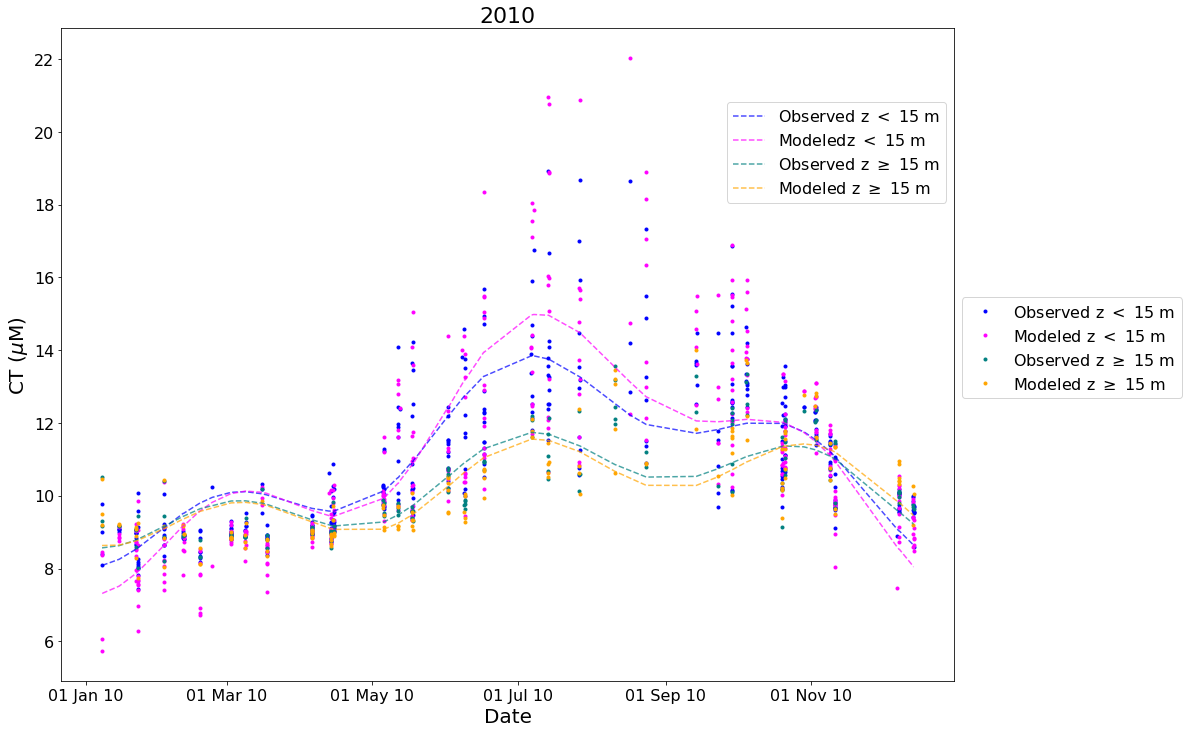

In [26]:
obsvar='CT'
modvar='mod_votemper'
start_date=dt.datetime(year,1,1)
end_date=dt.datetime(year,12,31)

ps,ax=ket.multi_timese_graph(data,year,obsvar,modvar,(16,12),depth_range=(15,15))
ps=ket.ts_trendline(ax,data,obsvar,modvar,start_date,end_date,'Z',(15,15),'z','m')
ax.legend(handles=ps,bbox_to_anchor=[1,.9,0,0])

## Observed Temperature and model Temperature over time for different regions

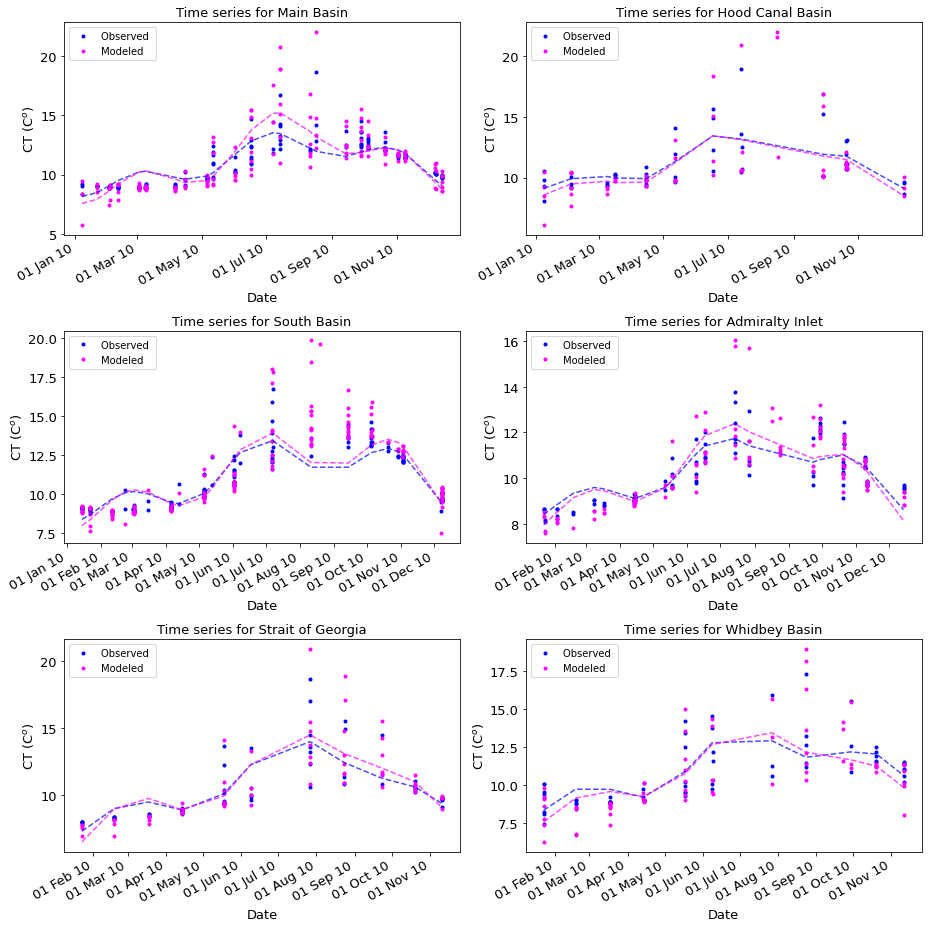

In [27]:
ax=ket.TsByRegion(datreg,data.Basin.unique(),obsvar,modvar,year,loc='upper left',units='(C$^o$)',trendline=True)

## Observed Temperature and model Temperature over time individual depths

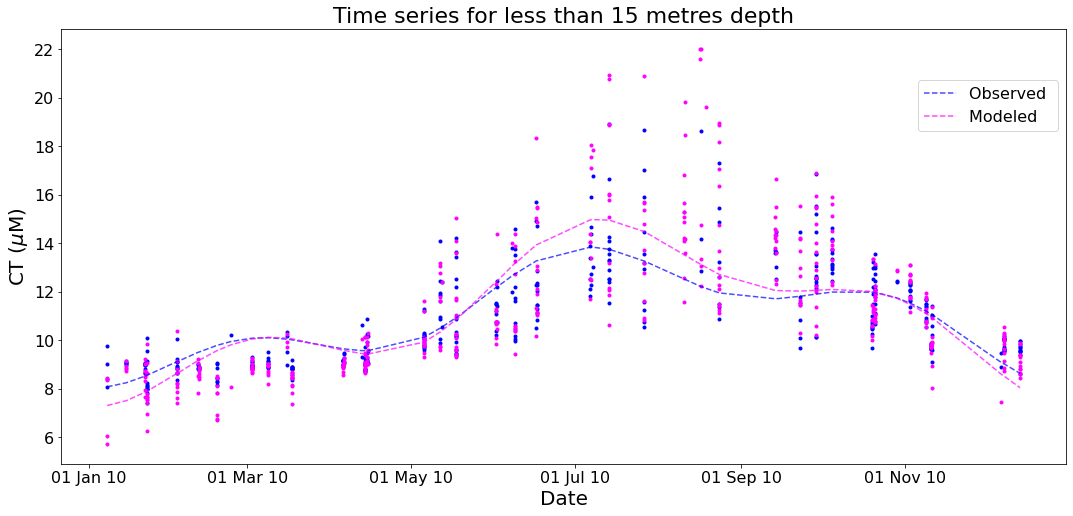

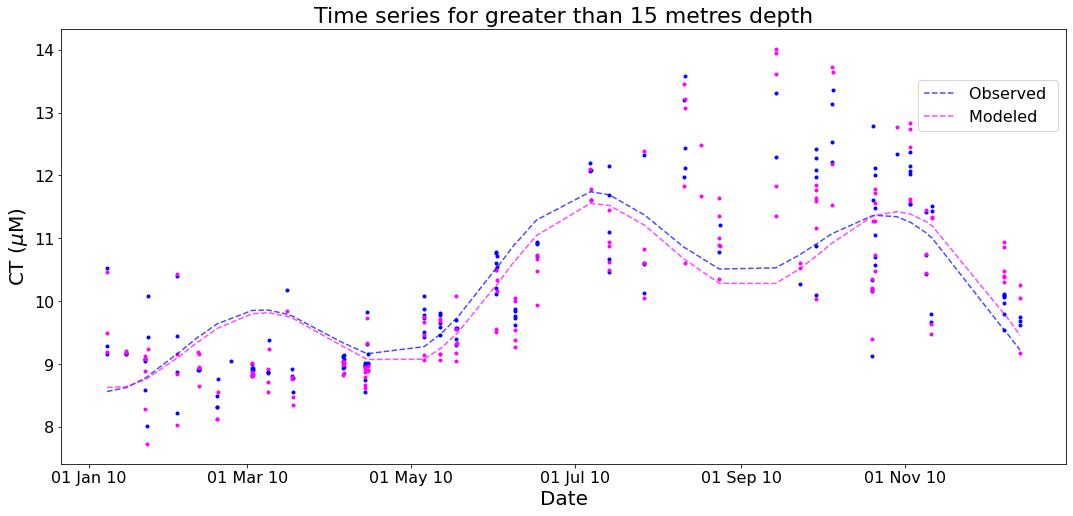

In [28]:
title='Time series for less than 15 metres depth'
ax=TsFormat(data[data.Z < 15],obsvar,modvar,year,title)
ps=ket.ts_trendline(ax,data[(data.Z < 15)],obsvar,modvar,start_date,end_date)
ax.legend(handles=ps,bbox_to_anchor=[1,.9,0,0])

title='Time series for greater than 15 metres depth'
ax=TsFormat(data[data.Z > 15],obsvar,modvar,year,title)
ps=ket.ts_trendline(ax,data[data.Z > 15],obsvar,modvar,start_date,end_date)
ax.legend(handles=ps,bbox_to_anchor=[1,.9,0,0])

# Error vs time of year

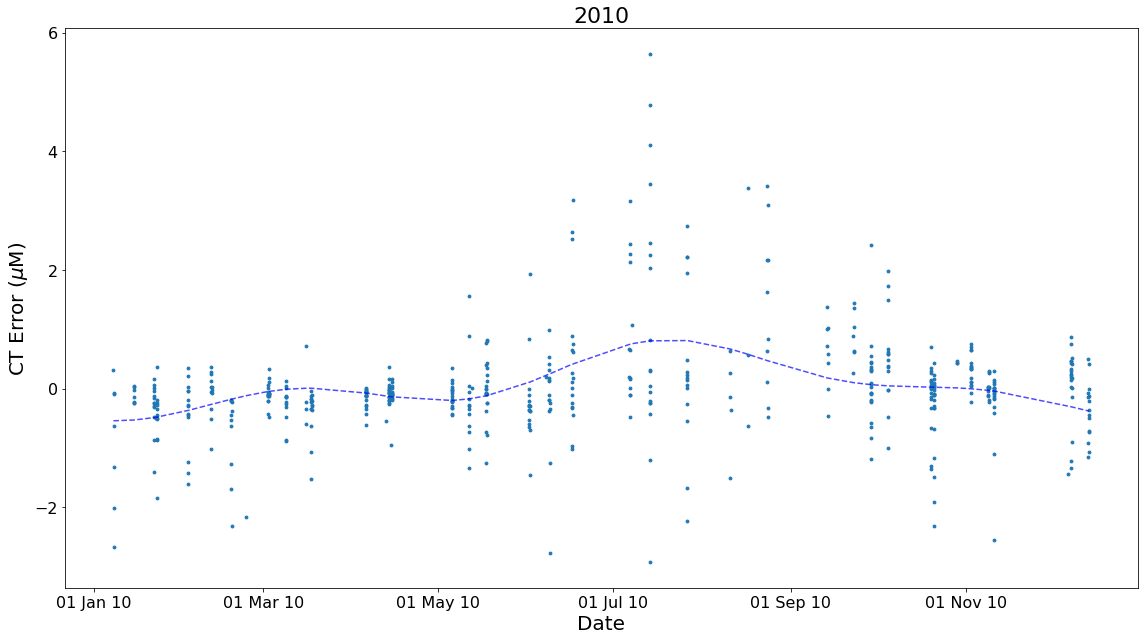

In [29]:
ax=ket.multi_timerror_graph(data,datyear,year,obsvar,modvar,(16,9))
ps=ket.ts_trendline(ax,data,obsvar,modvar,start_date,end_date,error=True)

# Log transformed Chlorophyll
## Observed Chlorophyll and model Chlorophyll over time with depth (log Transformed)

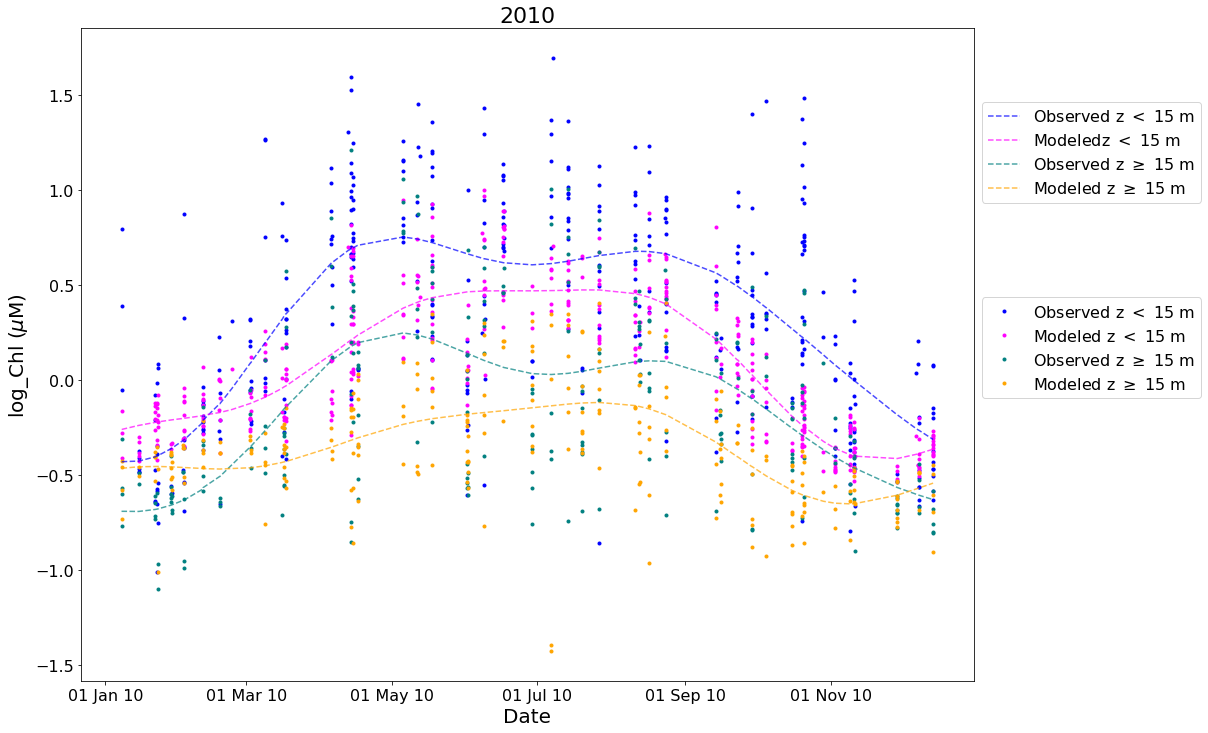

In [30]:
obsvar='log_Chl'
modvar='log_mod_Chl'
start_date=dt.datetime(year,1,1)
end_date=dt.datetime(year,12,31)

ps,ax=ket.multi_timese_graph(data_Pheo,year,obsvar,modvar,(16,12),depth_range=(15,15))
ps=ket.ts_trendline(ax,data_Pheo,obsvar,modvar,start_date,end_date,'Z',(15,15),'z','m')
ax.legend(handles=ps,bbox_to_anchor=[1,.9,0,0])

## Observed Chlorophyll and model Chlorophyll over time for different regions (Log transformed)

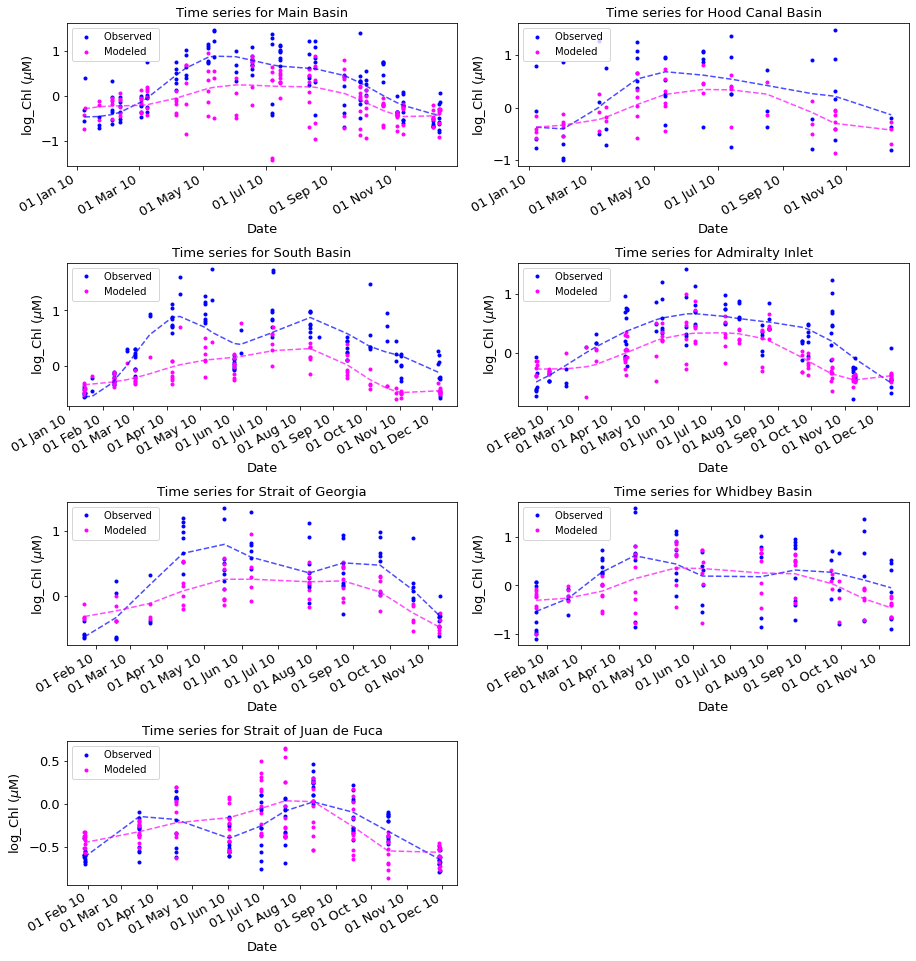

In [31]:
obsvar='log_Chl'
modvar='log_mod_Chl'

ax=ket.TsByRegion(datreg_Pheo,data_Pheo.Basin.unique(),obsvar,modvar,year,loc='upper left',trendline=True)

## Observed Chlorophyll and model Chlorophyll over time individual depths

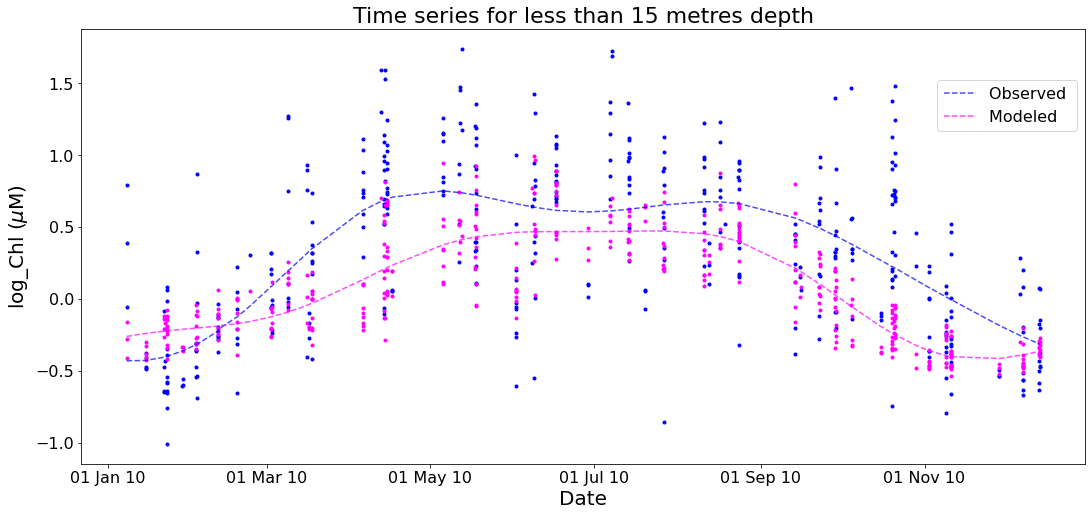

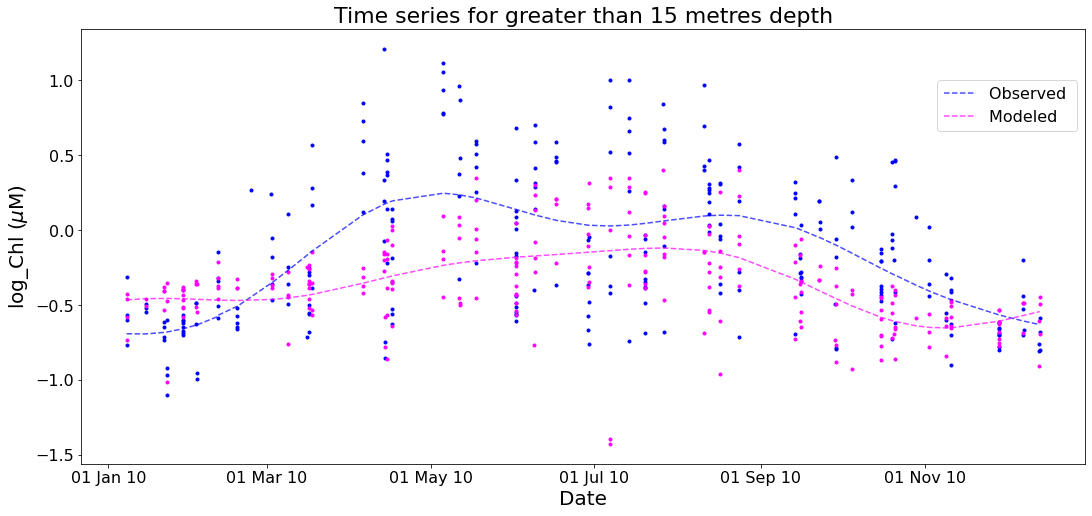

In [32]:
title='Time series for less than 15 metres depth'
ax=TsFormat(data_Pheo[data_Pheo.Z < 15],obsvar,modvar,year,title)
ps=ket.ts_trendline(ax,data_Pheo[data_Pheo.Z < 15],obsvar,modvar,start_date,end_date)
ax.legend(handles=ps,bbox_to_anchor=[1,.9,0,0])

title='Time series for greater than 15 metres depth'
ax=TsFormat(data_Pheo[data_Pheo.Z > 15],obsvar,modvar,year,title)
ps=ket.ts_trendline(ax,data_Pheo[data_Pheo.Z > 15],obsvar,modvar,start_date,end_date)
ax.legend(handles=ps,bbox_to_anchor=[1,.9,0,0])

## Model Error over time

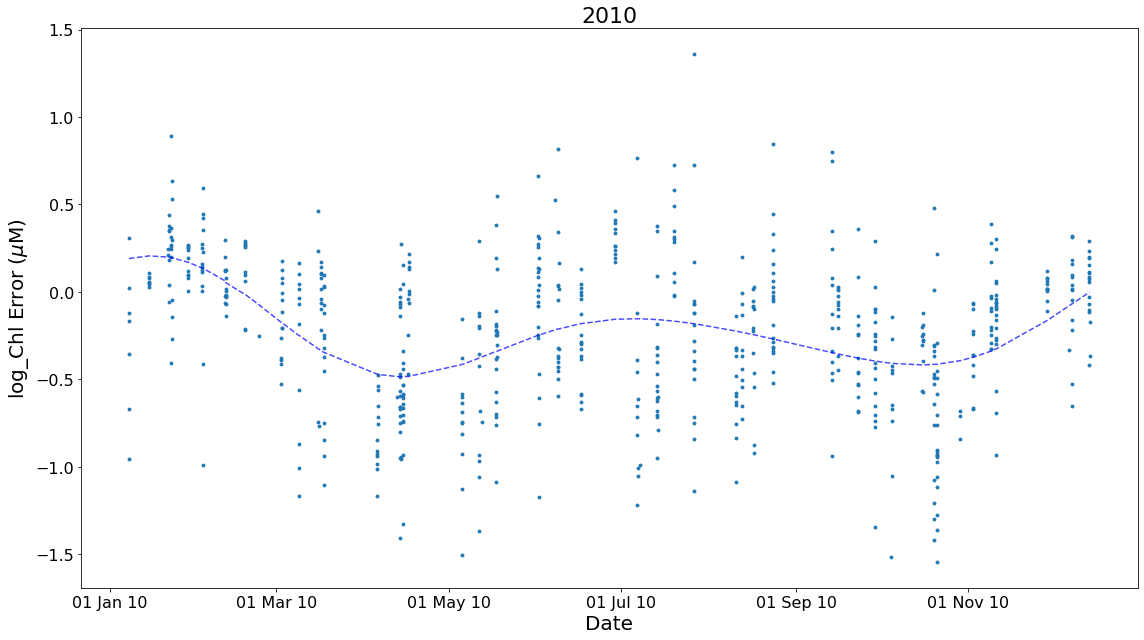

In [33]:
ax=ket.multi_timerror_graph(data_Pheo,datyear_Pheo,year,obsvar,modvar,(16,9))
ps=ket.ts_trendline(ax,data_Pheo,obsvar,modvar,start_date,end_date,error=True)

# Untransformed Chlorophyll
## Observed Chlorophyll and model Chlorophyll over time with depth

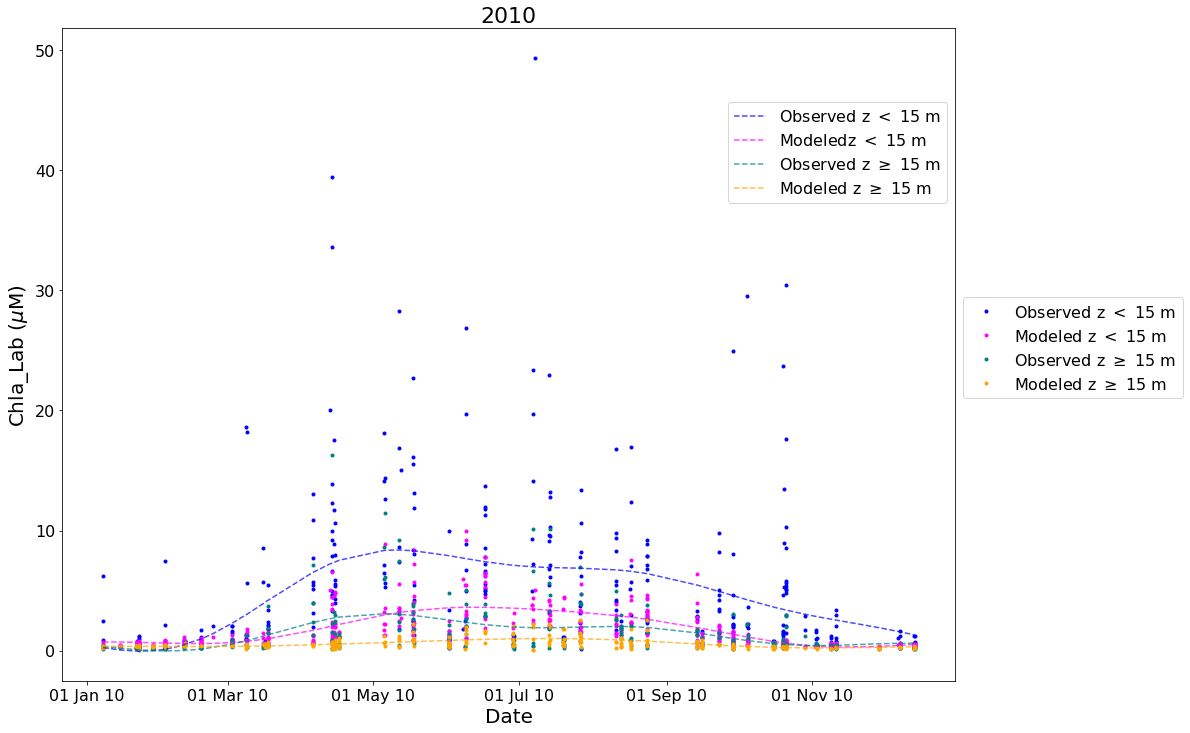

In [34]:
obsvar='Chla_Lab'
modvar='mod_Chl'
start_date=dt.datetime(year,1,1)
end_date=dt.datetime(year,12,31)

ps,ax=ket.multi_timese_graph(data_Pheo,year,obsvar,modvar,(16,12),depth_range=(15,15))
ps=ket.ts_trendline(ax,data_Pheo,obsvar,modvar,start_date,end_date,'Z',(15,15),'z','m')
ax.legend(handles=ps,bbox_to_anchor=[1,.9,0,0])

## Observed Chlorophyll and model Chlorophyll over time for different regions

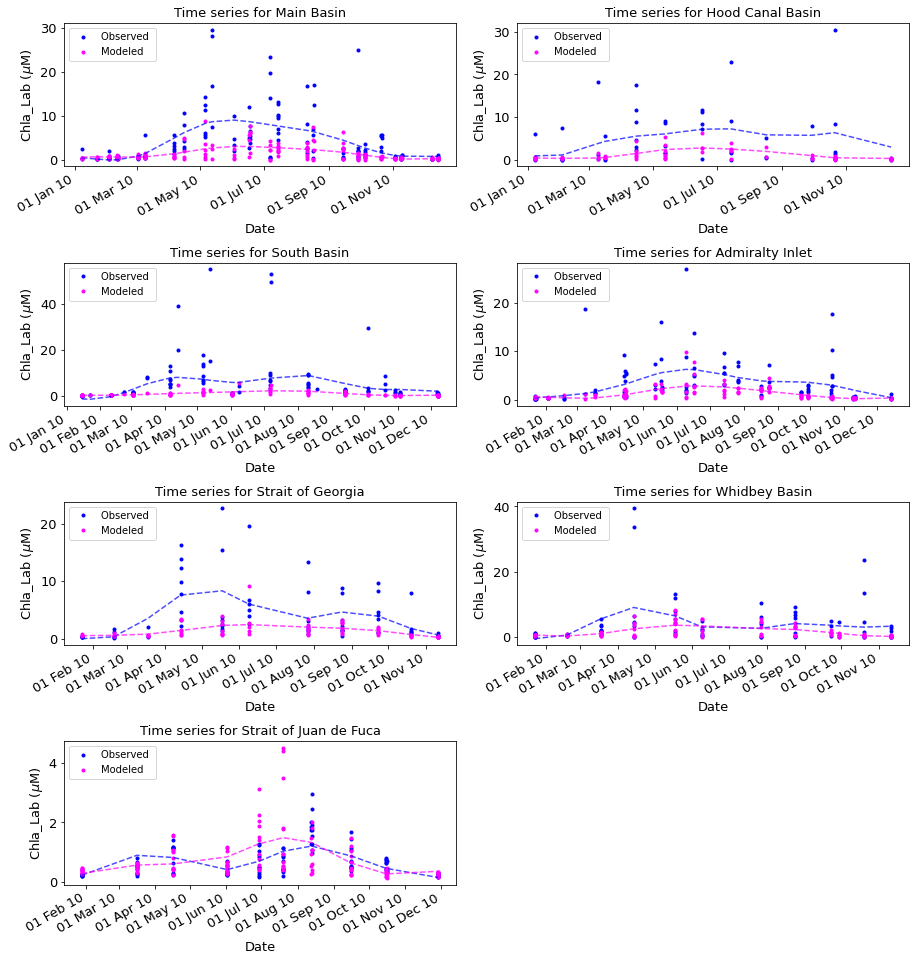

In [35]:
ax=ket.TsByRegion(datreg_Pheo,data_Pheo.Basin.unique(),obsvar,modvar,year,loc='upper left',trendline=True)

## Observed Chlorophyll and model Chlorophyll over time individual depths

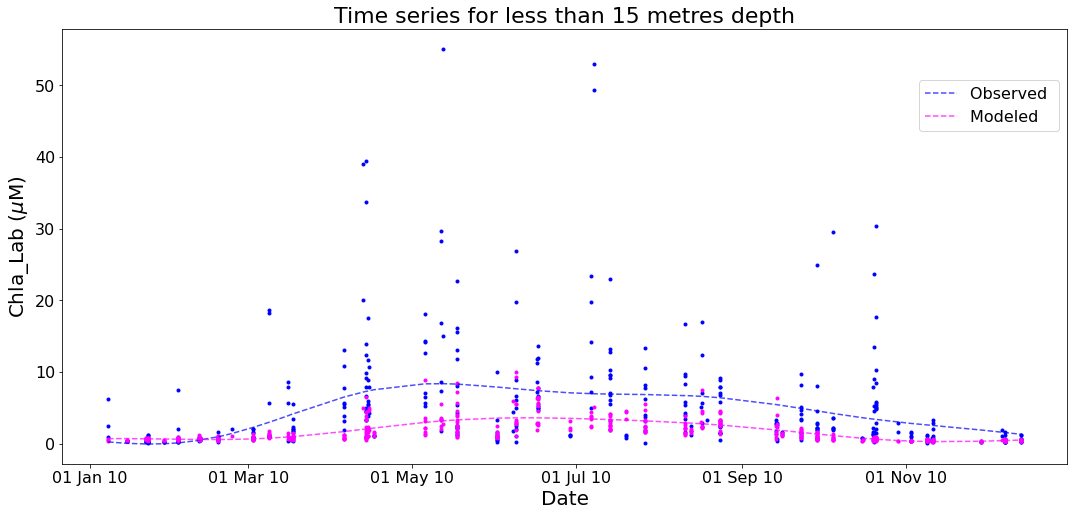

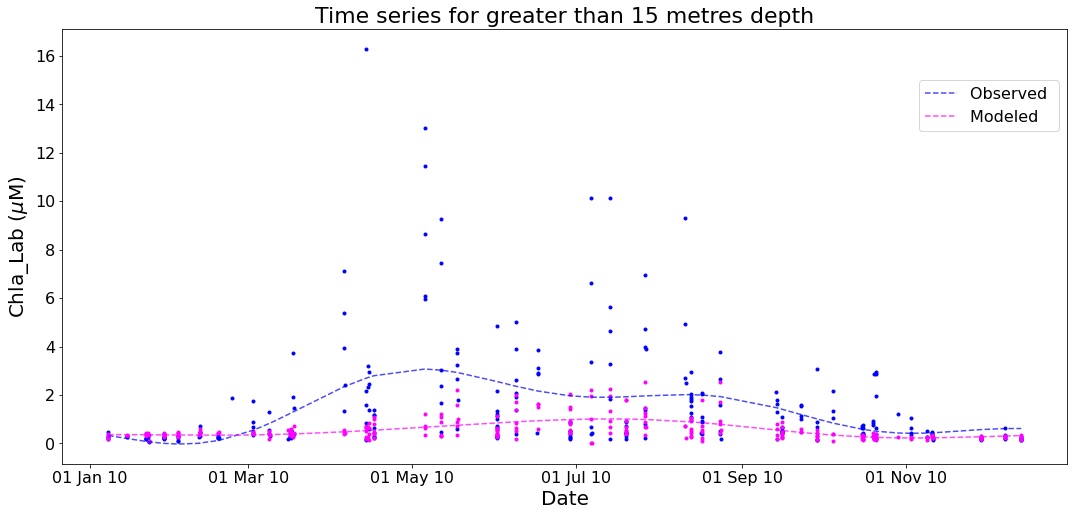

In [36]:
title='Time series for less than 15 metres depth'
ax=TsFormat(data_Pheo[data_Pheo.Z < 15],obsvar,modvar,year,title)
ps=ket.ts_trendline(ax,data_Pheo[data_Pheo.Z < 15],obsvar,modvar,start_date,end_date)
ax.legend(handles=ps,bbox_to_anchor=[1,.9,0,0])

title='Time series for greater than 15 metres depth'
ax=TsFormat(data_Pheo[data_Pheo.Z > 15],obsvar,modvar,year,title)
ps=ket.ts_trendline(ax,data_Pheo[data_Pheo.Z > 15],obsvar,modvar,start_date,end_date)
ax.legend(handles=ps,bbox_to_anchor=[1,.9,0,0])

## Model Error over time

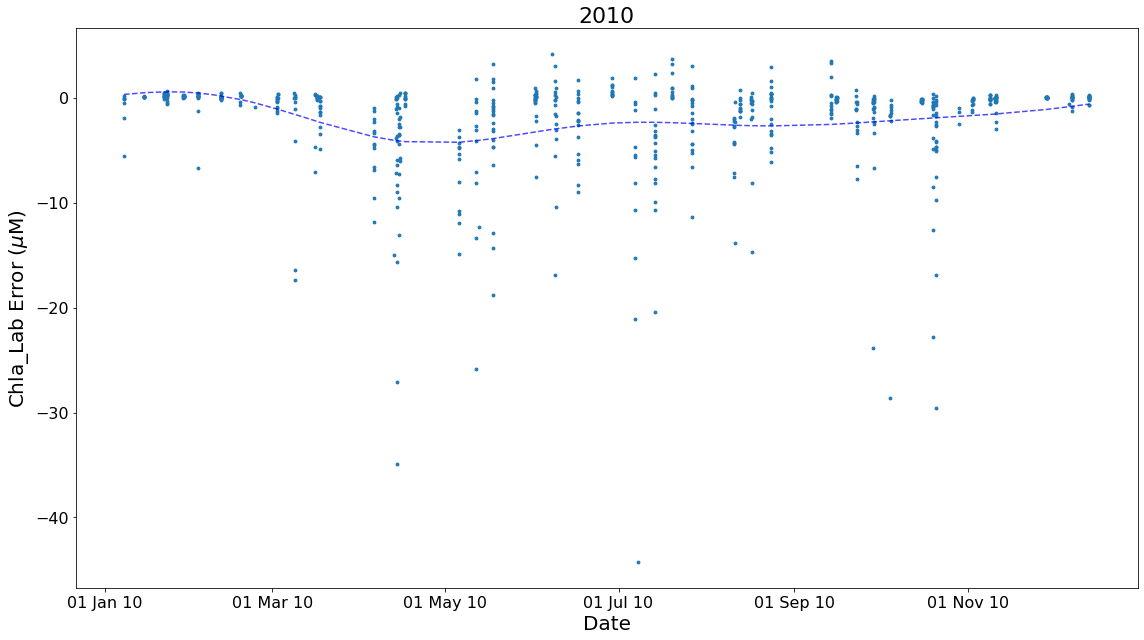

In [37]:
ax=ket.multi_timerror_graph(data_Pheo,datyear_Pheo,year,obsvar,modvar,(16,9))
ps=ket.ts_trendline(ax,data_Pheo,obsvar,modvar,start_date,end_date,error=True)